In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import io
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
games = pd.read_csv("nba_game_data_with_all_features_final.csv")

In [3]:
games["home_away"] = (games["home_away"] == "Home").astype(int)
X = games.drop(columns=["win", "result", "date", "team", "opponent", "year", "Year", "Year_opponent", "points_scored", "points_allowed", "point_differential"])
y = games["win"]  # Target variable

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [5]:
duplicates = X_train.merge(X_test, how='inner')
print(f"Number of duplicate rows in train & test set: {len(duplicates)}")


Number of duplicate rows in train & test set: 0


In [6]:
print(y_test.value_counts(normalize=True))

win
0    0.500715
1    0.499285
Name: proportion, dtype: float64


win                             1.000000e+00
point_differential              7.979754e-01
home_win                        6.223614e-01
away_win                        5.323338e-01
points_scored                   4.810622e-01
NRtg                            2.859286e-01
season_win_pct                  2.778135e-01
ORtg                            2.456692e-01
DRtg_opponent                   2.218676e-01
rolling_point_differential      1.722376e-01
wins_last_10                    1.705365e-01
wins_last_5                     1.467950e-01
home_points_scored_rolling5     1.287707e-01
home_win_pct                    1.230595e-01
head_to_head_wins               1.205411e-01
away_win_pct                    1.200123e-01
home_away                       1.167716e-01
win_streak                      9.095644e-02
points_scored_rolling5          7.368367e-02
Pace_opponent                   5.151907e-02
weighted_points_scored          4.243129e-02
games_last_5                    6.690118e-03
games_last

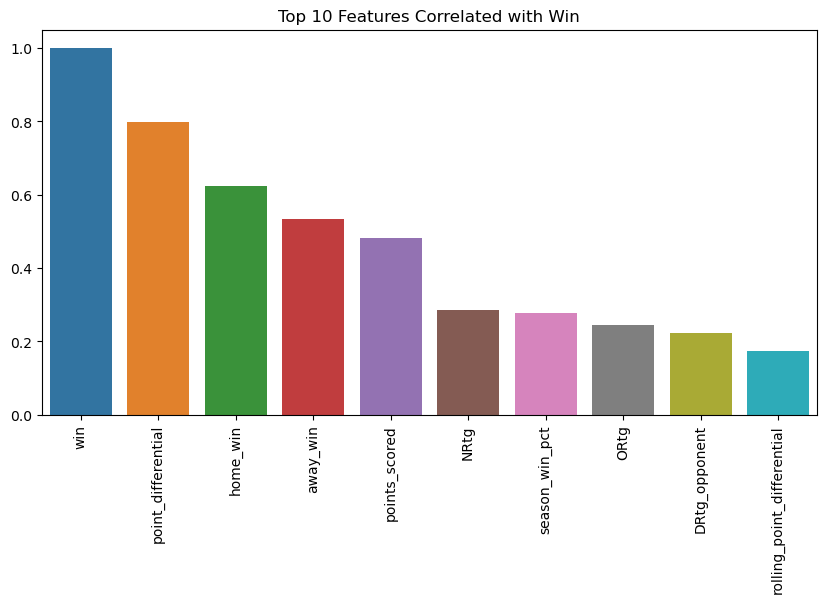

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_games = games.select_dtypes(include=[np.number])


correlations = numeric_games.corr()["win"].sort_values(ascending=False)


print(correlations)


plt.figure(figsize=(10, 5))
sns.barplot(x=correlations.index[:10], y=correlations.values[:10])
plt.xticks(rotation=90)
plt.title("Top 10 Features Correlated with Win")
plt.show()

In [ ]:

from sklearn.model_selection import cross_val_score
leak_features = ["home_win", "away_win"]

X_filtered = X.drop(columns=leak_features)


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)


cross_val_scores = cross_val_score(model, X_filtered, y, cv=5, scoring="accuracy")
print(f"New Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"New Mean Accuracy: {cross_val_scores.mean():.4f}")


New Cross-Validation Accuracy Scores: [0.66809728 0.65164521 0.58369099 0.52970651 0.60415175]
New Mean Accuracy: 0.6075


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")


best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate performance
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Model Accuracy: {accuracy:.4f}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Model Accuracy: 0.6602


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# wider search space
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 1000, 1200, 1500, 2000],
    "max_depth": [1, 3, 5, 10, 15, 20, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", None]
}


random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of different combinations to try
    cv=5,  
    scoring="accuracy",
    random_state=42,
    n_jobs=-1 
)


random_search.fit(X_train, y_train)


print(f"Best Parameters from Randomized Search: {random_search.best_params_}")


Best Parameters from Randomized Search: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 15}


In [ ]:
from sklearn.model_selection import GridSearchCV

# refined search
param_grid = {
    "n_estimators": [random_search.best_params_["n_estimators"] - 50, random_search.best_params_["n_estimators"], random_search.best_params_["n_estimators"] + 50],
    "max_depth": [random_search.best_params_["max_depth"] - 2, random_search.best_params_["max_depth"], random_search.best_params_["max_depth"] + 2] if random_search.best_params_["max_depth"] else [None],
    "min_samples_split": [max(2, random_search.best_params_["min_samples_split"] - 1), random_search.best_params_["min_samples_split"], random_search.best_params_["min_samples_split"] + 1],
    "min_samples_leaf": [max(1, random_search.best_params_["min_samples_leaf"] - 2), random_search.best_params_["min_samples_leaf"], random_search.best_params_["min_samples_leaf"] + 2],
    "max_features": [random_search.best_params_["max_features"]]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print(f"Best Parameters from Grid Search: {grid_search.best_params_}")


Best Parameters from Grid Search: {'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 950}


In [ ]:

optimized_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
optimized_rf.fit(X_train, y_train)


y_pred_rf = optimized_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Optimized Random Forest Accuracy: {accuracy_rf:.4f}")


Optimized Random Forest Accuracy: 0.6545


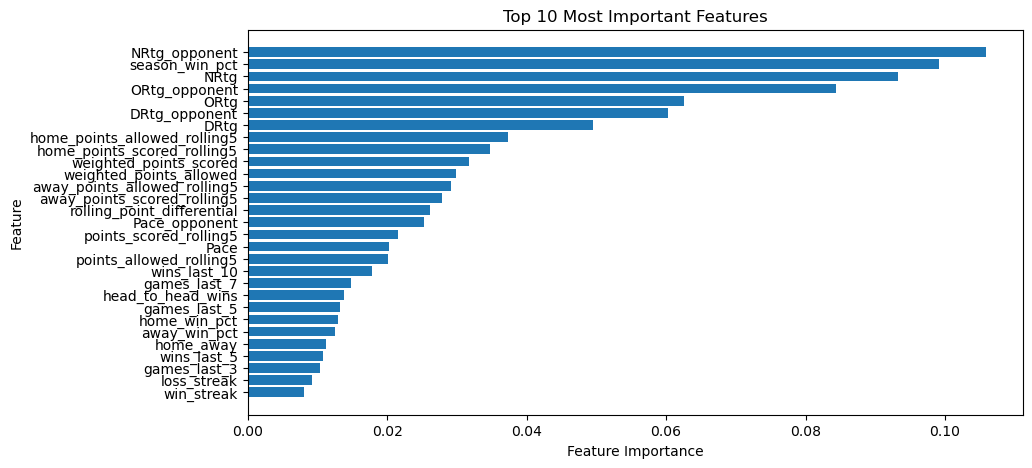

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


importances = optimized_rf.feature_importances_
feature_names = X_train.columns


sorted_indices = np.argsort(importances)[::-1]
sorted_features = np.array(feature_names)[sorted_indices]

# Plot top features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features[:-1], importances[sorted_indices][:-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.show()


In [19]:
print(X_filtered.columns)

Index(['home_away', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'ORtg_opponent',
       'DRtg_opponent', 'NRtg_opponent', 'Pace_opponent',
       'points_scored_rolling5', 'points_allowed_rolling5', 'wins_last_5',
       'wins_last_10', 'win_streak', 'loss_streak', 'rest_days',
       'home_win_pct', 'away_win_pct', 'head_to_head_wins', 'season_win_pct',
       'rolling_point_differential', 'weighted_points_scored',
       'weighted_points_allowed', 'games_last_3', 'games_last_5',
       'games_last_7', 'home_points_allowed_rolling5',
       'away_points_scored_rolling5', 'away_points_allowed_rolling5',
       'home_points_scored_rolling5'],
      dtype='object')


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


xgb_model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.4f}")


XGBoost Model Accuracy: 0.6609


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

V
xgb_random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5,  
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)


xgb_random_search.fit(X_train, y_train)

print(f"Best Parameters for XGBoost: {xgb_random_search.best_params_}")

best_xgb = xgb_random_search.best_estimator_
best_xgb.fit(X_train, y_train)


y_pred_xgb_best = best_xgb.predict(X_test)
accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"Tuned XGBoost Model Accuracy: {accuracy_xgb_best:.4f}")


Best Parameters for XGBoost: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Tuned XGBoost Model Accuracy: 0.6638


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ("rf", optimized_rf),
        ("xgb", best_xgb),
    ],
    voting="soft"  
)


ensemble_model.fit(X_train, y_train)


y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")


Ensemble Model Accuracy: 0.6602


In [19]:
print(X.columns)

Index(['home_away', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'ORtg_opponent',
       'DRtg_opponent', 'NRtg_opponent', 'Pace_opponent',
       'points_scored_rolling5', 'points_allowed_rolling5', 'wins_last_5',
       'wins_last_10', 'win_streak', 'loss_streak', 'rest_days', 'home_win',
       'away_win', 'home_win_pct', 'away_win_pct', 'head_to_head_wins',
       'season_win_pct', 'rolling_point_differential',
       'weighted_points_scored', 'weighted_points_allowed', 'games_last_3',
       'games_last_5', 'games_last_7', 'home_points_scored_rolling5',
       'home_points_allowed_rolling5', 'away_points_scored_rolling5',
       'away_points_allowed_rolling5'],
      dtype='object')


Top 15 Features: ['season_win_pct' 'NRtg_opponent' 'NRtg' 'ORtg_opponent' 'DRtg_opponent'
 'ORtg' 'weighted_points_allowed' 'weighted_points_scored'
 'home_points_allowed_rolling5' 'home_points_scored_rolling5' 'DRtg'
 'rolling_point_differential' 'points_allowed_rolling5' 'Pace_opponent'
 'points_scored_rolling5']
Feature Importances: [0.0754119  0.06772913 0.05738902 0.0569388  0.04729508 0.04426017
 0.04382702 0.04355135 0.04044245 0.03966359 0.03873121 0.03698147
 0.03350316 0.03335886 0.03300178]


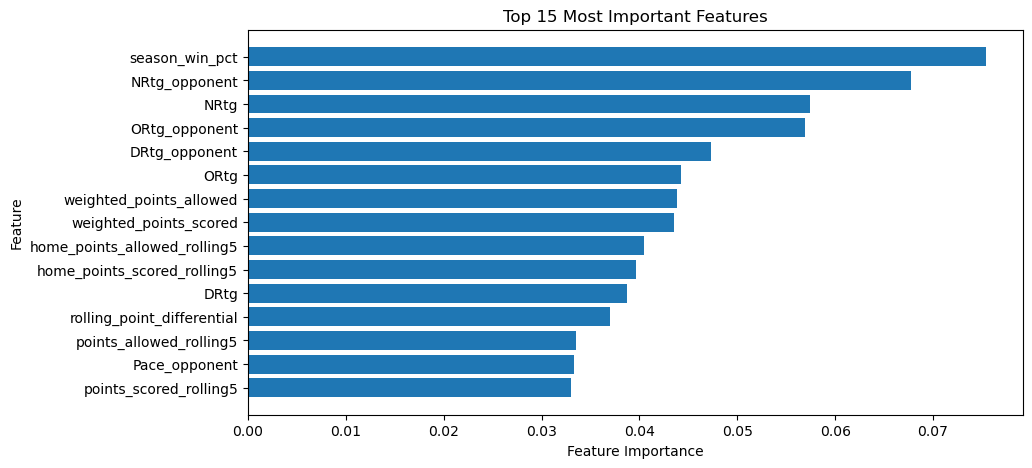

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


feature_importances = model.feature_importances_[:len(X_train.columns)]  


feature_names = np.array(X_train.columns)


sorted_indices = np.argsort(feature_importances)[::-1]  
sorted_indices = sorted_indices[:len(feature_names)]  


sorted_features = feature_names[sorted_indices]
sorted_importances = feature_importances[sorted_indices]


top_n = min(15, len(sorted_features))  # Select up to 15 features
selected_features = sorted_features[:top_n]
selected_importances = sorted_importances[:top_n]

print(f"Top {top_n} Features: {selected_features}")
print(f"Feature Importances: {selected_importances}")


plt.figure(figsize=(10, 5))
plt.barh(selected_features[::-1], selected_importances[::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Most Important Features")
plt.show()


In [28]:
print(X_filtered.columns)


Index(['home_away', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'ORtg_opponent',
       'DRtg_opponent', 'NRtg_opponent', 'Pace_opponent',
       'points_scored_rolling5', 'points_allowed_rolling5', 'wins_last_5',
       'wins_last_10', 'win_streak', 'loss_streak', 'rest_days',
       'home_win_pct', 'away_win_pct', 'head_to_head_wins', 'season_win_pct',
       'rolling_point_differential', 'weighted_points_scored',
       'weighted_points_allowed', 'games_last_3', 'games_last_5',
       'games_last_7', 'home_points_allowed_rolling5',
       'away_points_scored_rolling5', 'away_points_allowed_rolling5',
       'home_points_scored_rolling5'],
      dtype='object')


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize model
model = RandomForestClassifier(random_state=42)

# Forward Selection
sfs = SFS(model, 
          k_features=15,
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5,
         n_jobs=-1)

sfs.fit(X_filtered, y)


selected_features = list(sfs.k_feature_names_)
print("Best Features:", selected_features)


Best Features: ['home_away', 'ORtg_opponent', 'DRtg_opponent', 'NRtg_opponent', 'Pace_opponent', 'loss_streak', 'rest_days', 'season_win_pct', 'rolling_point_differential', 'weighted_points_scored', 'weighted_points_allowed', 'games_last_3', 'games_last_7', 'away_points_scored_rolling5', 'away_points_allowed_rolling5']


In [37]:
X_top = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
ensemble_model.fit(X_train, y_train)
y_pred_top = ensemble_model.predict(X_test)
accuracy_top = accuracy_score(y_test, y_pred_top)
print(f"Ensemble Model Accuracy with TSelected Features: {accuracy_top:.4f}")

Ensemble Model Accuracy with TSelected Features: 0.6609


In [31]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ensemble_model, X_top, y, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Accuracy Scores: [0.66452074 0.65021459 0.63733906 0.65783822 0.68074445]
Mean Accuracy: 0.6581314138307819


In [ ]:

removed_features = list(set(X_filtered) - set(selected_features))

selected_features = list(selected_features)
max_acc = 0.6652

for feature in removed_features:
    selected_features.append(feature)  
    X_adjusted = X[selected_features]
    X_adjusted = X_adjusted.loc[:, ~X_adjusted.columns.duplicated()]

    X_train, X_test, y_train, y_test = train_test_split(X_adjusted, y, test_size=0.2, random_state=42)


    ensemble_model.fit(X_train, y_train)

    # Evaluate accuracy
    y_pred_adjusted = ensemble_model.predict(X_test)
    new_accuracy = accuracy_score(y_test, y_pred_adjusted)

    print(f"Accuracy with {feature} reintroduced: {new_accuracy:.4f}")

    # If accuracy improves, keep the feature
    
    if new_accuracy >= max_acc:
        print(f"Keeping {feature} in the model.\n")
        max_acc = new_accuracy
    else:
        print(f"{feature} did not help, removing it again.\n")
        selected_features.remove(feature)  


Accuracy with games_last_5 reintroduced: 0.6609
games_last_5 did not help, removing it again.

Accuracy with ORtg reintroduced: 0.6595
ORtg did not help, removing it again.

Accuracy with home_win_pct reintroduced: 0.6595
home_win_pct did not help, removing it again.

Accuracy with wins_last_5 reintroduced: 0.6581
wins_last_5 did not help, removing it again.

Accuracy with away_win_pct reintroduced: 0.6588
away_win_pct did not help, removing it again.

Accuracy with Pace reintroduced: 0.6631
Pace did not help, removing it again.

Accuracy with DRtg reintroduced: 0.6581
DRtg did not help, removing it again.

Accuracy with wins_last_10 reintroduced: 0.6588
wins_last_10 did not help, removing it again.

Accuracy with head_to_head_wins reintroduced: 0.6631
head_to_head_wins did not help, removing it again.

Accuracy with home_points_scored_rolling5 reintroduced: 0.6609
home_points_scored_rolling5 did not help, removing it again.

Accuracy with points_allowed_rolling5 reintroduced: 0.6609
p

In [ ]:
# Finalized best features after testing
X_final = X[selected_features]  


X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


ensemble_model.fit(X_train, y_train)

# Evaluate final accuracy
y_pred_final = ensemble_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"🔹 Final Ensemble Model Accuracy after Feature Adjustments: {final_accuracy:.4f}")


🔹 Final Ensemble Model Accuracy after Feature Adjustments: 0.6652


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# wider search space
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 1000, 1200, 1500, 2000],
    "max_depth": [1, 3, 5, 10, 15, 20, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", "log2", None]
}


random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring="accuracy",
    random_state=42,
    n_jobs=-1 
)


random_search.fit(X_train, y_train)


print(f"Best Parameters from Randomized Search: {random_search.best_params_}")

Best Parameters from Randomized Search: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 15}


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [random_search.best_params_["n_estimators"] - 50, random_search.best_params_["n_estimators"], random_search.best_params_["n_estimators"] + 50],
    "max_depth": [random_search.best_params_["max_depth"] - 2, random_search.best_params_["max_depth"], random_search.best_params_["max_depth"] + 2] if random_search.best_params_["max_depth"] else [None],
    "min_samples_split": [max(2, random_search.best_params_["min_samples_split"] - 1), random_search.best_params_["min_samples_split"], random_search.best_params_["min_samples_split"] + 1],
    "min_samples_leaf": [max(1, random_search.best_params_["min_samples_leaf"] - 2), random_search.best_params_["min_samples_leaf"], random_search.best_params_["min_samples_leaf"] + 2],
    "max_features": [random_search.best_params_["max_features"]]
}


grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print(f"Best Parameters from Grid Search: {grid_search.best_params_}")


Best Parameters from Grid Search: {'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 1000}


In [ ]:

optimized_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
optimized_rf.fit(X_train, y_train)


y_pred_rf = optimized_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Optimized Random Forest Accuracy: {accuracy_rf:.4f}")


Optimized Random Forest Accuracy: 0.6545


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}


xgb_random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  
    cv=5, 
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)


xgb_random_search.fit(X_train, y_train)


print(f"Best Parameters for XGBoost: {xgb_random_search.best_params_}")


best_xgb = xgb_random_search.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred_xgb_best = best_xgb.predict(X_test)
accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"Tuned XGBoost Model Accuracy: {accuracy_xgb_best:.4f}")


Best Parameters for XGBoost: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Tuned XGBoost Model Accuracy: 0.6588


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Define ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ("rf", optimized_rf),
        ("xgb", best_xgb),
    ],
    voting="soft",  
    weights = [0.225, 0.775]
)


ensemble_model.fit(X_train, y_train)


y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")



Ensemble Model Accuracy: 0.6638


In [55]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
stacked_ensemble = StackingClassifier(
    estimators=[("rf", optimized_rf), ("xgb", best_xgb)],
    final_estimator=LogisticRegression()
)
stacked_ensemble.fit(X_train, y_train)
y_pred_stacked = stacked_ensemble.predict(X_test)

# Evaluate accuracy
stacked_accuracy = accuracy_score(y_test, y_pred_stacked)
print(f"Stacked Model Accuracy: {stacked_accuracy:.4f}")

Stacked Model Accuracy: 0.6624


In [67]:
from sklearn.ensemble import GradientBoostingClassifier

stacked_ensemble = StackingClassifier(
    estimators=[("rf", optimized_rf), ("xgb", best_xgb)],
    final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=0.1)
)
stacked_ensemble.fit(X_train, y_train)
y_pred_stacked = stacked_ensemble.predict(X_test)

stacked_accuracy = accuracy_score(y_test, y_pred_stacked)
print(f"Stacked Model Accuracy with GBC: {stacked_accuracy:.4f}")


Stacked Model Accuracy with GBC: 0.6574


In [69]:
from sklearn.neural_network import MLPClassifier

stacked_nn = StackingClassifier(
    estimators=[("rf", optimized_rf), ("xgb", best_xgb)],
    final_estimator=MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500)
)

stacked_nn.fit(X_train, y_train)
y_pred_nn = stacked_nn.predict(X_test)

stacked_nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f"Stacked Model Accuracy with Neural Network: {stacked_nn_accuracy:.4f}")


Stacked Model Accuracy with Neural Network: 0.6552


In [70]:
from sklearn.ensemble import GradientBoostingClassifier

# Adjust hyperparameters
gbc_meta = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05)

stacked_gbc = StackingClassifier(
    estimators=[("rf", optimized_rf), ("xgb", best_xgb)],
    final_estimator=gbc_meta
)

stacked_gbc.fit(X_train, y_train)
y_pred_gbc = stacked_gbc.predict(X_test)

stacked_gbc_accuracy = accuracy_score(y_test, y_pred_gbc)
print(f"Stacked Model Accuracy with Tuned GBC: {stacked_gbc_accuracy:.4f}")


Stacked Model Accuracy with Tuned GBC: 0.6559


In [ ]:
optimized_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)
rf_probs = optimized_rf.predict_proba(X_test)[:, 1] 
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]  

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from itertools import product

# Define weight search space
weight_values = np.arange(0.1, 0.91, 0.05)  

# Store best results
best_accuracy = 0
best_weights = None


for w1, w2 in product(weight_values, repeat=2):
    if np.isclose(w1 + w2, 1.0):  

        y_pred_ensemble_probs = (w1 * rf_probs) + (w2 * xgb_probs)
        y_pred_ensemble = np.round(y_pred_ensemble_probs)  #
        
        acc = accuracy_score(y_test, y_pred_ensemble)
        
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_weights = (w1, w2)


print(f"Best Ensemble Weights: {best_weights}, Best Accuracy: {best_accuracy:.4f}")


✅ Best Ensemble Weights: (0.20000000000000004, 0.8000000000000002), Best Accuracy: 0.6631


In [77]:
# Keep probabilities instead of rounding
y_pred_ensemble_probs = (0.2 * rf_probs) + (0.8 * xgb_probs)
from sklearn.metrics import log_loss
ensemble_log_loss = log_loss(y_test, y_pred_ensemble_probs)
print(f"Soft Voting Log Loss: {ensemble_log_loss:.4f}")

Soft Voting Log Loss: 0.6117


In [ ]:
best_log_loss = float("inf")
best_weights = None

for w1 in np.arange(0.05, 0.96, 0.01): 
    w2 = 1 - w1  


    y_pred_probs = (w1 * rf_probs) + (w2 * xgb_probs)


    log_loss_score = log_loss(y_test, y_pred_probs)


    if log_loss_score < best_log_loss:
        best_log_loss = log_loss_score
        best_weights = (w1, w2)

print(f"Best Soft Voting Weights: {best_weights}, Best Log Loss: {best_log_loss:.4f}")



✅ Best Soft Voting Weights: (0.19, 0.81), Best Log Loss: 0.6117


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


stacker = LogisticRegression()
stacker.fit(np.column_stack([rf_probs, xgb_probs]), y_train)


stacked_probs = stacker.predict_proba(np.column_stack([rf_probs, xgb_probs]))[:, 1]
stacked_log_loss = log_loss(y_test, stacked_probs)

print(f"Stacked Model Log Loss: {stacked_log_loss:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [1398, 5590]

In [ ]:
rf_probs_train = rf.predict_proba(X_train)[:, 1]  
xgb_probs_train = xgb.predict_proba(X_train)[:, 1]


stacker.fit(np.column_stack([rf_probs_train, xgb_probs_train]), y_train)


NameError: name 'rf' is not defined